# 2.Veriyi Yüklemek

In [ ]:
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random,os,glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [ ]:
#Drive'a yüklenen resimleri Google Colab Notebook'a çekme
dir_path = '/content/drive/MyDrive/rgb/rgb_jpg'

In [ ]:
#Google Colab Notebook ile Google Drive'ın eşleştirilmesi
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train_dir = os.path.join(dir_path, "train")
test_dir = os.path.join(dir_path, "test")
val_dir = os.path.join(dir_path, "val")

In [ ]:
target_size = ( 224,224)
labels = {"benign": 0, "malignant":1}

# 3.Veri Setinden Örneklere Ulaşmak

In [ ]:
import os
from imutils import paths
import cv2
import numpy as np
from sklearn.utils import shuffle
from multiprocessing import Pool

def visualize_img(image_batch,label_batch):
    """

    Veri seti içerisinden görüntü görselleştirir. (Alt Alta beşer beşer resimleri gösterir.)

    Parametreler:
    image_batch: Görüntülere ait matris bilgilerini tutar.

    label_batch: Görüntünün ait olduğu sınıf bilgisini tutan liste.

    """
    plt.figure(figsize= (10,10))
    for n in range(10):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(np.array(list(labels.keys()))[label_batch[n]].title())
      plt.axis("off")

def load_image(image_path, target_size, waste_labels):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    label = image_path.split(os.path.sep)[-2]
    label = waste_labels[label]
    return img, label

def load_datasets(path, waste_labels, target_size):
    x = []
    labels = []

    image_paths = sorted(list(paths.list_images(path)))

    num_processors = os.cpu_count() - 1

    with Pool(num_processors) as p:
        results = p.starmap(load_image, [(image_path, target_size, waste_labels) for image_path in image_paths])

    for img, label in results:
        x.append(img)
        labels.append(label)

    x, labels = shuffle(x, labels, random_state=42)

    print(f"X Boyutu: {np.array(x).shape}")
    print(f"Label Sınıf Sayısı: {len(np.unique(labels))} Gözlem Sayısı: {len(labels)}")

    return x, labels


# Her bir dizinden veri yüklemek için 
train_x, train_labels = load_datasets(train_dir, labels, target_size)
test_x, test_labels = load_datasets(test_dir, labels, target_size)
val_x, val_labels = load_datasets(val_dir, labels, target_size)


X Boyutu: (6000, 224, 224, 3)
Label Sınıf Sayısı: 2 Gözlem Sayısı: 6000
X Boyutu: (2001, 224, 224, 3)
Label Sınıf Sayısı: 2 Gözlem Sayısı: 2001
X Boyutu: (2000, 224, 224, 3)
Label Sınıf Sayısı: 2 Gözlem Sayısı: 2000


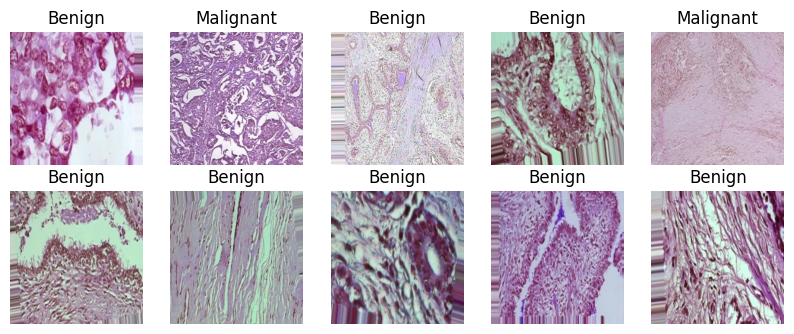

In [ ]:
visualize_img(train_x,train_labels)

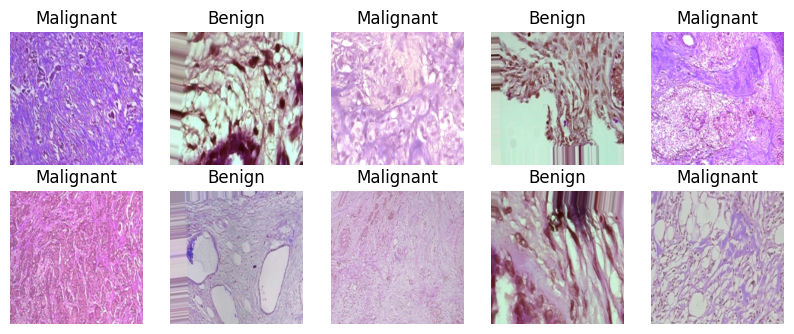

In [ ]:
visualize_img(test_x,test_labels)

# 4.Veriyi Hazırlamak

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen= ImageDataGenerator(rescale=1./255)
batch_size = 32
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2001 images belonging to 2 classes.


# 5.Modelleme



1.   Sequential
2.   Evrişim Katmanı(Conv2D)
3.   Pooling Katmanı
4.   Aktivasyon Katmanı ( örn: "relu")
5.   Flattening Katmanı
6.   Dense Katmanı
7.   Dropout Katmanı

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), padding="same",activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), padding="same",activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])


NOT: Bu modelde, çıkış katmanında bir birim (units=1) kullanılmıştır çünkü 2 sınıf olduğu için tek bir çıkış düğümüne ihtiyaç vardır. activation parametresi sigmoid olarak ayarlanmıştır çünkü bu bir ikili sınıflandırma problemidir ve çıkışın 0 ile 1 arasında olması istenir.

In [ ]:
# Modelin derlenmesi
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])



In [ ]:
# Modelin özetini gösterme
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 35, 35, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [ ]:
# Callback'lerin tanımlanması
callbacks = [
    EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min"),
    ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
]

In [ ]:
# Modelin eğitimi
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks
)

Epoch 1/10
187/187 [==============================] - ETA: 0s - loss: 0.4553 - accuracy: 0.7956
Epoch 1: val_loss improved from inf to 0.32247, saving model to mymodel.h5
187/187 [==============================] - 406s 2s/step - loss: 0.4553 - accuracy: 0.7956 - val_loss: 0.3225 - val_accuracy: 0.8921
Epoch 2/10
187/187 [==============================] - ETA: 0s - loss: 0.3001 - accuracy: 0.8809
Epoch 2: val_loss improved from 0.32247 to 0.25854, saving model to mymodel.h5
187/187 [==============================] - 357s 2s/step - loss: 0.3001 - accuracy: 0.8809 - val_loss: 0.2585 - val_accuracy: 0.9037
Epoch 3/10
187/187 [==============================] - ETA: 0s - loss: 0.2535 - accuracy: 0.8986
Epoch 3: val_loss improved from 0.25854 to 0.21870, saving model to mymodel.h5
187/187 [==============================] - 345s 2s/step - loss: 0.2535 - accuracy: 0.8986 - val_loss: 0.2187 - val_accuracy: 0.9173
Epoch 4/10
187/187 [==============================] - ETA: 0s - loss: 0.2298 - accu

In [ ]:
model.save("model_keras_best2.h5")

In [ ]:
model_name = "my_model.h5"  
model.save(model_name)  

from google.colab import drive
import shutil

# Google Drive'a bağlanın
drive.mount('/content/drive')

# Model dosyasını Google Drive'a taşıma
source = model_name
destination = "/content/drive/My Drive/" + model_name  # Kaydetmek istediğimiz klasör yolu
shutil.move(source, destination)

print("Model başarıyla Google Drive'a kaydedildi.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model başarıyla Google Drive'a kaydedildi.


In [ ]:
import joblib

# Modeli `.pkl` formatında kaydet
model_name_pkl = "my_model.pkl"
joblib.dump(model, model_name_pkl)

drive.mount('/content/drive')

# Model dosyasını Google Drive'a taşıma
source = model_name_pkl
destination = "/content/drive/My Drive/" + model_name_pkl 
shutil.move(source, destination)

print("Model başarıyla Google Drive'a kaydedildi.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model başarıyla Google Drive'a kaydedildi.


In [ ]:
import pickle

# Modelin ağırlıklarını ve mimarisini ayrı ayrı kaydetme
with open("model_weights.pkl", "wb") as f:
    pickle.dump(model.get_weights(), f)

with open("model_architecture.pkl", "wb") as f:
    pickle.dump(model.to_json(), f)

In [ ]:
import shutil
import os

# Model dosyasının olduğu yol
model_path = "model_keras_best2.h5"

# Hedef masaüstü yolu
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")

# Model dosyasını masaüstüne kopyalama
shutil.copy(model_path, desktop_path)

print("Model başarıyla masaüstüne kaydedildi.")

Model başarıyla masaüstüne kaydedildi.


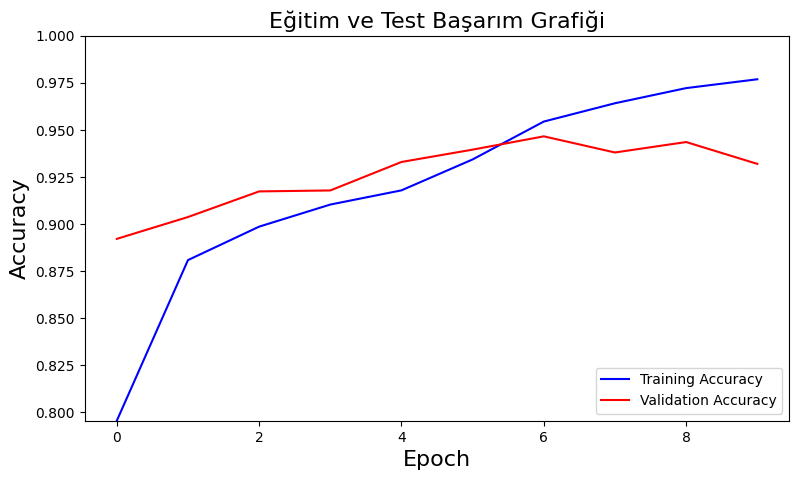

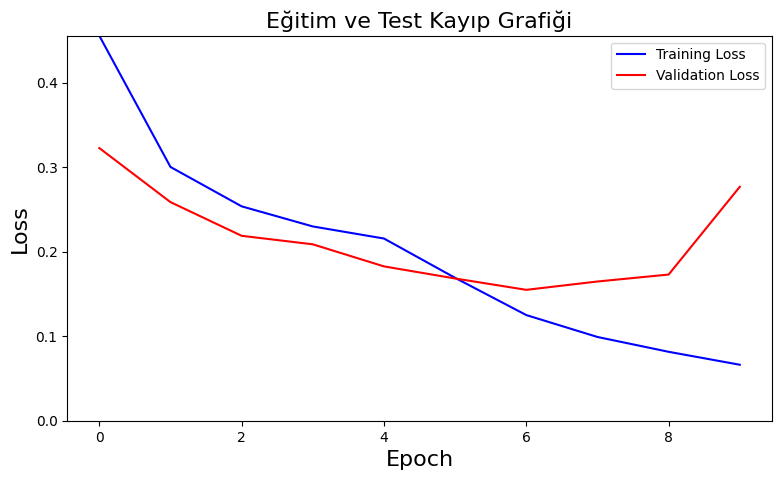

In [ ]:
#############################
# Accuracy ve Loss Grafikleri
#############################
#-------------------------------------- Grafik 1: Accuracy----------------------------#
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], color="b", label="Training Accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.ylim([min(min(history.history['accuracy']), min(history.history['val_accuracy'])), 1])
plt.title("Eğitim ve Test Başarım Grafiği", fontsize=16)



#-------------------------------------- Grafik 2: Loss ------------------------------#

plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"], color="b", label="Training Loss")
plt.plot(history.history["val_loss"], color="r", label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.ylim([0, max(max(history.history['loss']), max(history.history['val_loss']))])
plt.title("Eğitim ve Test Kayıp Grafiği", fontsize=16)
plt.show()

In [ ]:
def model_testing(path):
  img =image.load_img(path,target_size=(target_size))
  img = image.img_to_array(img,dtype=np.uint8)
  img= np.array(img)/255.0
  p = model.predict(img.reshape(1,224,224,3))
  predicted_class = np.argmax(p[0])

  return img,p,predicted_class

In [ ]:
from keras.preprocessing import image
import numpy as np

def model_testing(image_path):
    img = image.load_img(image_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Rescale to [0, 1]

    prediction = model.predict(img_array)
    predicted_class = "malignant" if prediction > 0.5 else "benign"

    return img, prediction, predicted_class

In [ ]:
img1,p1,predicted_class1 =model_testing('/content/drive/MyDrive/rgb/rgb_jpg/test/malignant/cancer_malignant (3001).jpg')
img2,p2,predicted_class2 =model_testing('/content/drive/MyDrive/rgb/rgb_jpg/test/malignant/cancer_malignant (3033).jpg')
img3,p3,predicted_class3 =model_testing('/content/drive/MyDrive/rgb/rgb_jpg/test/benign/cancer_benign (3039).jpg')
img4,p4,predicted_class4 =model_testing('/content/drive/MyDrive/rgb/rgb_jpg/test/benign/cancer_benign (3080).jpg')

1/1 [==============================] - 0s 32ms/step


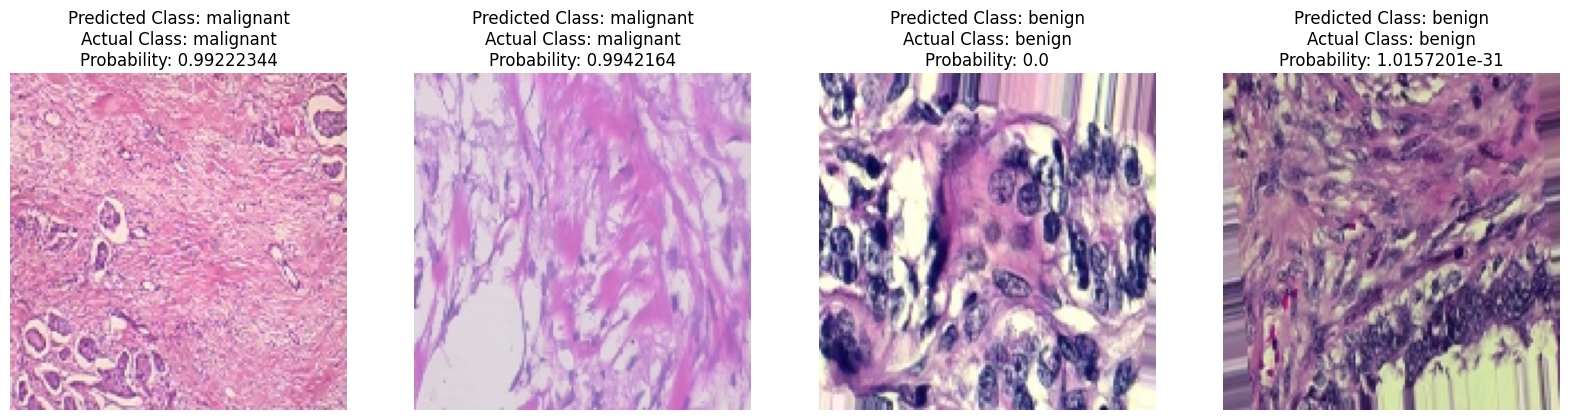

In [ ]:
actual_class1 = "malignant"
actual_class2 = "benign"


plt.figure(figsize=(20, 60))

plt.subplot(141)
plt.axis("off")
plt.imshow(img1)
plt.title("Predicted Class: " + predicted_class1 + "\n" + "Actual Class: " + actual_class1 + "\n" + "Probability: " + str(p1[0][0]))

plt.subplot(142)
plt.axis("off")
plt.imshow(img2)
plt.title("Predicted Class: " + predicted_class2 + "\n" + "Actual Class: " + actual_class1 + "\n" + "Probability: " + str(p2[0][0]))

plt.subplot(143)
plt.axis("off")
plt.imshow(img3)
plt.title("Predicted Class: " + predicted_class3 + "\n" + "Actual Class: " + actual_class2 + "\n" + "Probability: " + str(p3[0][0]))

plt.subplot(144)
plt.axis("off")
plt.imshow(img4)
plt.title("Predicted Class: " + predicted_class4 + "\n" + "Actual Class: " + actual_class2 + "\n" + "Probability: " + str(p4[0][0]))

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

In [ ]:
loss, acc, precision, recall = model.evaluate(test_generator, batch_size=32)

63/63 [==============================] - 48s 747ms/step - loss: 0.2816 - accuracy: 0.9395 - precision: 0.9695 - recall: 0.9083


In [ ]:
loss, acc, precision, recall = model.evaluate(test_generator, batch_size=32)

print("Test Loss:", loss)
print("Test Accuracy:", acc)
print("Test Precision:", precision)
print("Test Recall:", recall)

63/63 [==============================] - 43s 663ms/step - loss: 0.2816 - accuracy: 0.9395 - precision: 0.9705 - recall: 0.9097
Test Loss: 0.28158414363861084
Test Accuracy: 0.9395302534103394
Test Precision: 0.9705194234848022
Test Recall: 0.9096640348434448
